# Практика сегментация

## Dataset

Мы будем использовать Oxford-IIIT Pet Dataset. Он состоит из 37 классов собак и кошек, на каждый класс около 200 картинок. В датасете есть как боксы, так и маски. В датасете около 7 тысяч изображений.  

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Скачаем данные и распакуем

In [1]:
# %%capture out
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
# !rm  images/*.mat

Заметим, у нас две папки в данных. Первая с `images` и вторая с разметкой масками как `binary` картинки.

## Импортируем нужные библиотеки

In [3]:
import os
import albumentations as A
import cv2
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.express as px
import plotly.io as pio
from torchmetrics import JaccardIndex
from plotly.subplots import make_subplots
from torchvision.transforms import v2
from torchvision import models
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from multiprocessing import cpu_count

pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU_THREADS = cpu_count()

## Готовим данные

Каждый пиксель изображения маски может принимать одно из трех значений: «1», «2» или «3». «1» означает, что данный пиксель изображения принадлежит классу «животное», «2» - классу «фон», «3» - классу «граница». Поскольку в этом примере демонстрируется задача двоичной сегментации (то есть присвоение одного из двух классов каждому пикселю), мы предварительно обработаем маску, поэтому она будет содержать только два уникальных значения: 0 если пиксель является фоном, и 1 если пиксель - это животное или граница.

In [4]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [5]:
class PetDataset(Dataset):
    def __init__(self, split="train", transform=None):
        images_train, images_test = train_test_split(
            os.listdir("images"), 
            random_state=142, 
            shuffle=True, 
            train_size=0.8
        )
        if split == "train":
            self.images_filenames = images_train
        else:
            self.images_filenames = images_test

        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join("images", image_filename))
        if image is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(
                "annotations", 
                "trimaps",
                image_filename.replace(".jpg", ".png")
            ),
            cv2.IMREAD_UNCHANGED,
        )
        if mask is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [6]:
train_dataset = PetDataset()
val_dataset = PetDataset(split="val")

### Выбираем аугментации для обучения

In [7]:
# ImageNet mean and std
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
normalize = A.Normalize(mean, std)
# Unnormalizer for visualisation
inv_normalize = v2.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)
# Train augmentations
train_transform = A.Compose([
    A.Resize(512, 512),
    A.Rotate(limit=90),
    A.RandomBrightnessContrast(
        brightness_limit=0.2, 
        contrast_limit=0.2
    ),
    normalize,
    ToTensorV2()
])
train_dataset = PetDataset("train", transform=train_transform)
# Val transforms
val_transform = A.Compose([
    A.Resize(512, 512),
    normalize,
    ToTensorV2()
])
val_dataset = PetDataset("Val", transform=val_transform)

Напишем функцию для визуализации датасетов 

In [8]:
def visualize_data(dataset:PetDataset, nrows=2, ncols=2):
    grid = make_subplots(rows=nrows, cols=ncols, column_titles=['Image', 'Mask'])
    for i in range(nrows):
        img, mask = dataset.__getitem__(i)
        # Normalized [C, H, W] (CUDA, float32) -> Unnormalized (original) [H, W, C] (CPU, uint8)
        img = v2.ToDtype(torch.uint8, scale=True)(inv_normalize(img)).cpu().permute(1, 2, 0)
        mask = mask.cpu()
        grid.add_trace(
            px.imshow(
                img, 
                height=img.shape[0], 
                width=img.shape[1],
            ).data[0],
            row=i+1,
            col=1
        ).update_yaxes(
            autorange=False, 
            range=[512, 0]
        ).add_trace(
            px.imshow(
                mask,
                height=mask.shape[0],
                width=mask.shape[1],
            ).data[0],
            row=i+1,
            col=2
        ).update_yaxes(
            autorange=False, 
            range=[512, 0],
            visible=False
        ).update_xaxes(
            visible=False
        )
    grid.update_layout(
        height=900, 
        width=900, 
        coloraxis_showscale=False
    ).show()

Визуалиризуем примеры (в трейн уже используется аугментация)

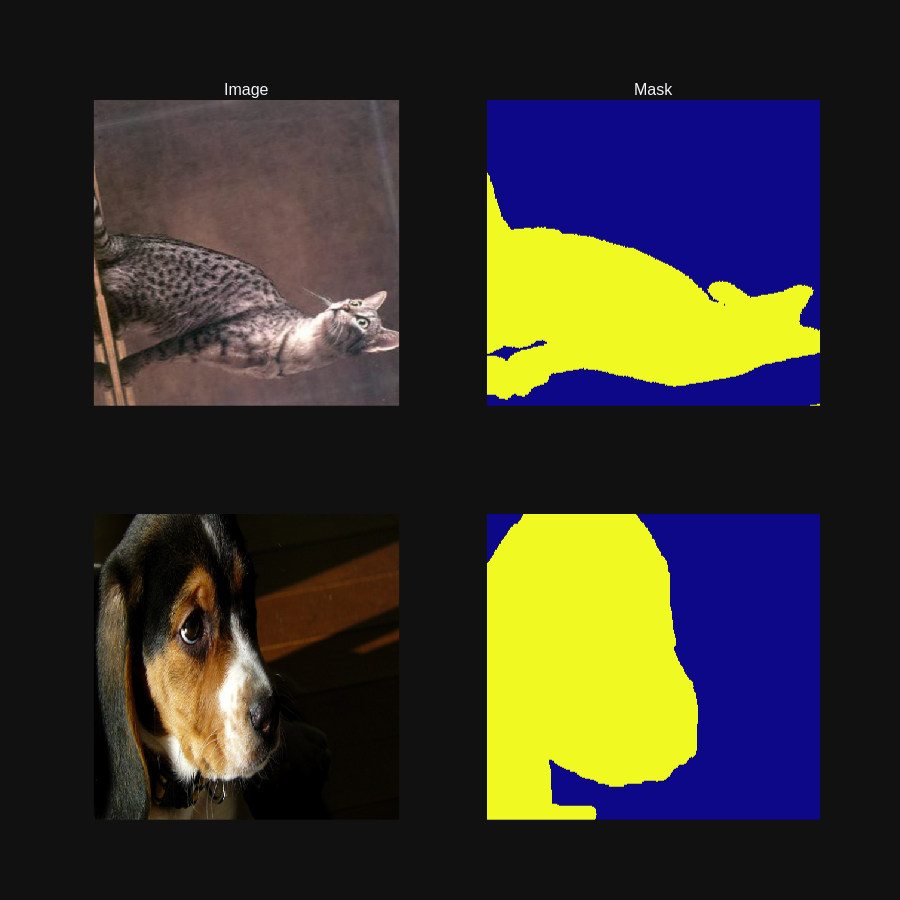

Validation dataset


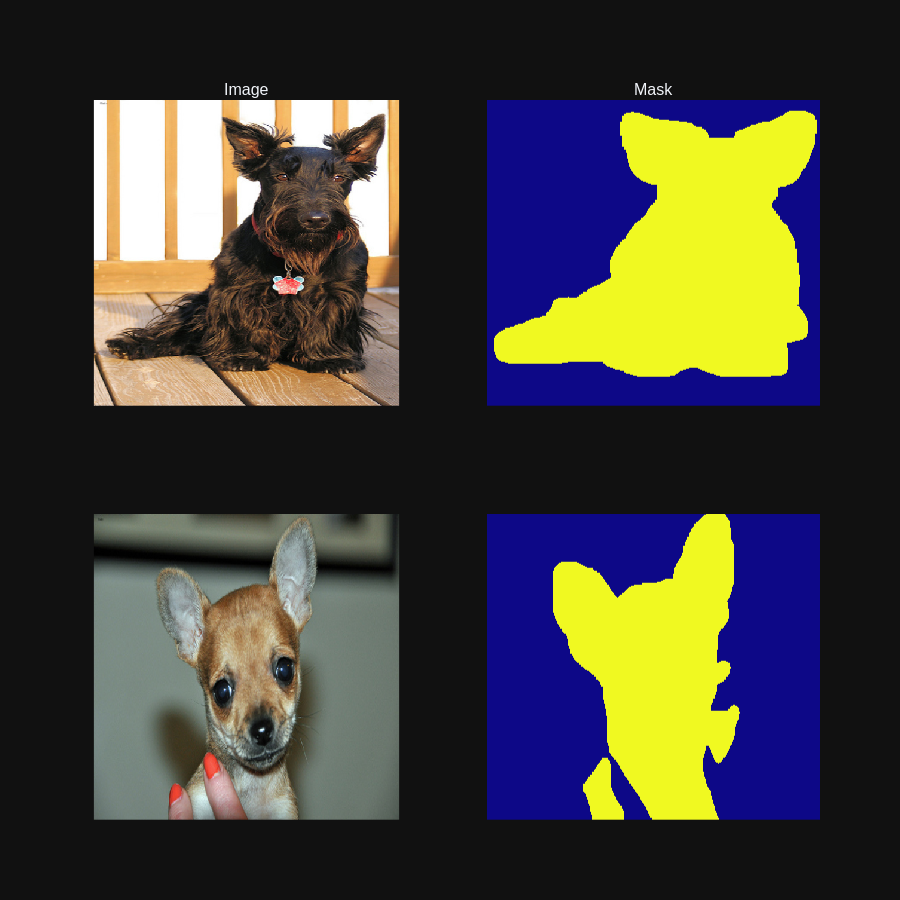

In [9]:
visualize_data(train_dataset)
print('Validation dataset')
visualize_data(val_dataset)

## Модель и обучение
В качестве целевой метрики выберем $\text{Intersection over Union (IoU)}$. Считать метрику будем на *CPU*, чтобы распараллелить вычисления - видеокарта для обучения модели, процессор для рассчета метрики

In [10]:
IoU = JaccardIndex(task='binary', threshold=0.5).to('cpu')

Напишем класс модели. Для *fine-tuning* возьмем модель `fcn_resnet50` с `learning_rate=1e-4`, оптимизатором `RAdam`. Сам `learning_rate` во время обучения будет иметь поведение функции косинуса, а не константой

In [11]:
class SegModel(pl.LightningModule):
    
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = 8
        self.learning_rate = 1e-4
        # FCN Resnet50
        self.net = models.segmentation.fcn_resnet50(
            n_classes=2,
            weights=models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1,
        )
        # Replace classifier outputs for binary classification
        self.net.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
        self.net.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
        self.trainset = train_dataset
        self.valset = val_dataset
        # Binary cross-entropy
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.net(x)['out']

    def training_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img) # [B, 2, H, W]
        loss_val = self.criterion(out.max(1)[0], mask) # [B, 2, H, W] -> [B, H, W] with logits
        iou_score = IoU(out.max(1)[0].cpu(), mask.cpu()) # compute IoU on CPU
        self.log("train_loss", loss_val)
        self.log("train_iou", iou_score, prog_bar=True)
        return loss_val

    def configure_optimizers(self):
        opt = optim.RAdam(self.net.parameters(), lr=self.learning_rate)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(
            self.trainset, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=CPU_THREADS
        )

    def val_dataloader(self):
        return DataLoader(
            self.valset,
            batch_size=1,
            shuffle=False,
            num_workers=CPU_THREADS
        )

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)
        loss_val = self.criterion(out.max(1)[0], mask) # [B, 2, H, W] -> [B, H, W] with logits
        iou_score = IoU(out.max(1)[0].cpu(), mask.cpu()) # compute IoU on CPU
        self.log("val_loss", loss_val, prog_bar=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True)

### Обучение
Инициализируем модель и `trainer`. Обучать будем 5 раз (5 эпох), **сохраним чекпоинт для модели**, которая показала **наилучший показатель целевой метрики** ($\text{IoU}$) **на валидационной выборке**

In [12]:
model = SegModel(train_dataset, val_dataset)
trainer = pl.Trainer(
    accelerator=DEVICE,
    max_epochs=5,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
        LearningRateMonitor("epoch")
    ],
    enable_progress_bar=True,
)

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-02-04 14:10:23.523443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 14:10:23.523477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 14:10:23.523927: E external/local_xla/xla/stream_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Валидация
Загрузим наилучшую модель и оценим её качество на валидационном даталоадере

In [14]:
trainer.validate(
    model, 
    ckpt_path='lightning_logs/version_4/checkpoints/epoch=3-step=2956.ckpt', 
    dataloaders=model.val_dataloader()
)

Restoring states from the checkpoint path at lightning_logs/version_4/checkpoints/epoch=3-step=2956.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs/version_4/checkpoints/epoch=3-step=2956.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.9111880660057068     │
│         val_loss          │    0.09402752667665482    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.09402752667665482, 'val_iou': 0.9111880660057068}]

Напишем функцию для визуализации валидационного датасета

In [54]:
def visualise_predictions(dataloader:DataLoader, model:SegModel, nrows=4, ncols=3, threshold=0.5):
    iter_loader = iter(dataloader)
    grid = make_subplots(rows=nrows, cols=ncols, column_titles=['Image', 'True mask', 'Predicted mask'])
    for i in range(nrows):
        img, mask = next(iter_loader)
        with torch.no_grad():
            preds = model.eval()(img.to(DEVICE))
        mask_pred_logits = preds.max(1)[0] # logits
        mask_pred_sigm = nn.Sigmoid()(mask_pred_logits) # sigmoid for logits (binary classification)
        # Replace sigmoid output with threshold
        mask_pred_sigm[mask_pred_sigm < threshold] = 0
        mask_pred_sigm[mask_pred_sigm >= threshold] = 1
        batch_idx = 0 # only one element in val batch
        # Normalized [C, H, W] (CUDA, float32) -> Unnormalized (original) [H, W, C] (CPU, uint8)
        img_orig = v2.ToDtype(torch.uint8, scale=True)(inv_normalize(img[batch_idx])).cpu().permute(1, 2, 0)
        mask_pred = mask_pred_sigm[batch_idx].cpu()
        mask_true = mask[batch_idx].cpu()
        
        grid.add_trace(
            px.imshow(
                img_orig, 
                height=img_orig.shape[0], 
                width=img_orig.shape[1],
            ).data[0],
            row=i+1,
            col=1
        ).update_yaxes(
            autorange=False, 
            range=[512, 0]
        ).add_trace(
            px.imshow(
                mask_true,
                height=img_orig.shape[0],
                width=img_orig.shape[1],
            ).data[0],
            row=i+1,
            col=2
        ).add_trace(
            px.imshow(
                mask_pred,
                height=img_orig.shape[0],
                width=img_orig.shape[1],
            ).data[0],
            row=i+1,
            col=3
        ).update_yaxes(
            autorange=False, 
            range=[512, 0],
            visible=False
        ).update_xaxes(
            visible=False
        )
    grid.update_layout(
        height=1500, 
        width=1500, 
        coloraxis_showscale=False
    ).show()

Загружаем модель и даталоадер

In [55]:
val_loader = model.val_dataloader()
final_model = SegModel.load_from_checkpoint(
    'lightning_logs/version_4/checkpoints/epoch=3-step=2956.ckpt', 
    train_dataset=train_dataset,
    val_dataset=val_dataset
).to(DEVICE)

Визуализируем результат. **True mask** - маска из датасета, **Predicted mask** - предсказанная моделью маска

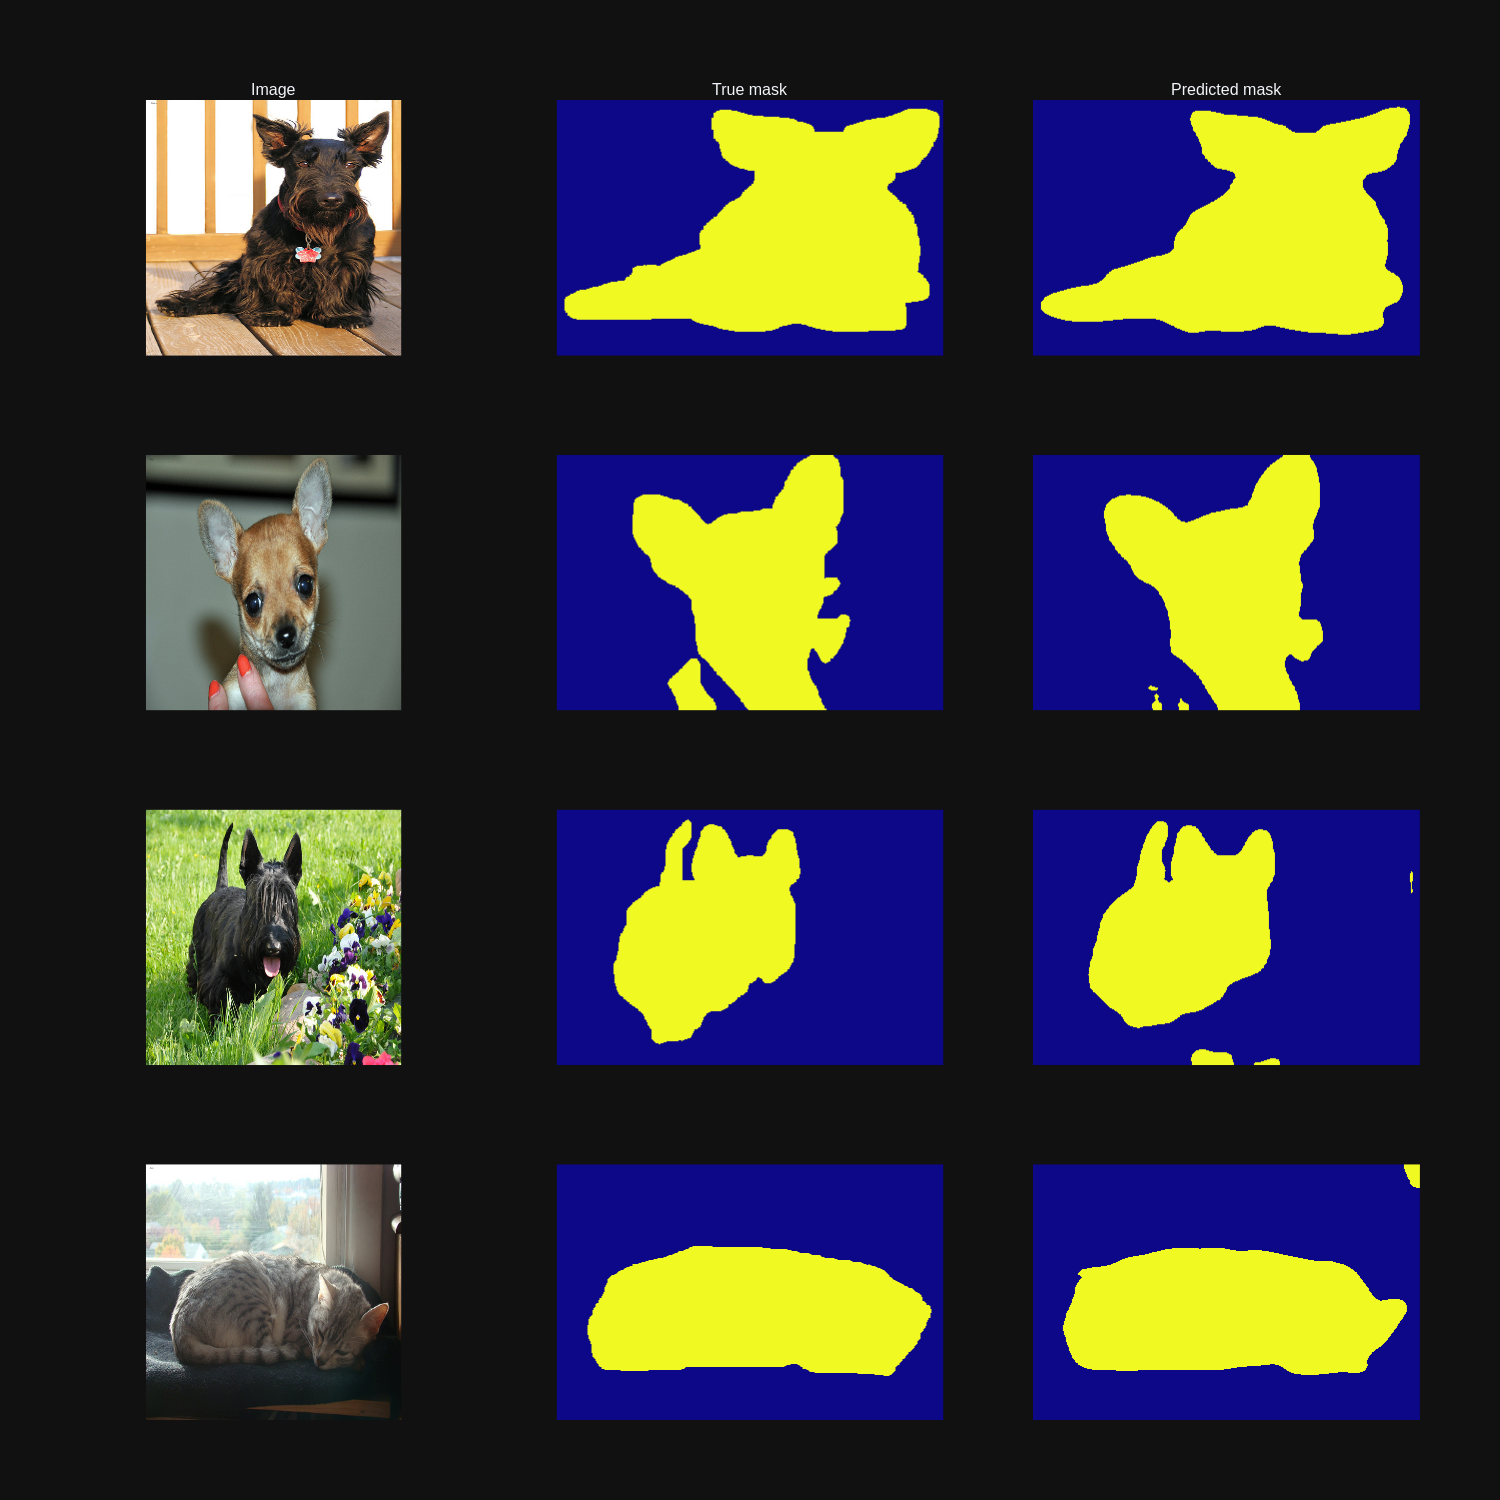

In [56]:
visualise_predictions(val_loader, model=final_model)

Из примеров видно, что модель очень хорошо решает задачу бинарной сегментации, о чем и говорит высокий показатель $\text{mIoU} \approx 0.91$